# Chaîne de traitement _data science_.
## _pipeline ML_ avec `python` 



Nous allons travailler, entraîner, configurer et utiliser des algorithmes _ML_ de régression. Nous tâcherons systématiquement d'en discuter les performances en nous appuyant sur des indicateurs pertinents.

On rappelle que le _dataset_ présente des données immobilières californiennes. Il compte des variables telles que la population, le salaire médian, le prix moyen d'un logement, _etc_. 

### Préparation de l'environnement

In [0]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# ignorer les warnings inutiles 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Reconstruction de l'environnement de fin de la première partie du _Workshop_

On va reconstituer le _kernel_ `python` de la première partie du _Workshop_. Vous pouvez executer le code sans vous soucier de son contenu jusqu'à la partie _Choisir et Entraîner un modèle_.

#### Import et chargement

In [0]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

#### _Split_

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

#### Pipeline de préparation

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
#création d'un objet encapsulant les trois fonctions essentielles du workshop précédent
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
#création de la pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
#selection des variables
housing_num = housing.select_dtypes(include=[np.number]) 
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
#pipeline complète
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### Choisir et Entraîner un modèle

Le travail effectué lors du précédent _workshop_ a abouti à plusieurs résultats :

- Nous avons réservé un jeu de données de test stratifié `strat_test_set`,
- nous en avons extrait les variables d'entrée `housing` et la colonne cible `housing_labels`,
- nous avons créé un _pipeline_ `full_pipeline` de préparation de la donné d'entraînement.
- nous avons utilisé ce _pipeline_ pour façonner un jeu de données `housing_prepared`.

Nous allons commencer par entrainer un modèle de `régression linéaire` avec nos données.

#### Premier modèle

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

C'est tout.
Notre modèle est prêt à faire des prédictions.
Nous allons lui présenter des données du jeux d'entraînement en prenant soin d'y appliquer le _pipeline_ de transformation

In [0]:
# On applique le full_pipeline sur quelques instances :
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Et on effectue la prédiction :
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


On peut comparer ces prédictions aux vraies valeurs :

In [0]:
print("Labels:", list(some_labels)) # vraies valeurs

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


### Evaluer / valider un modèle

Nos résultats ne semblent pas abérrants mais pour vérifier notre entrainement nous allons appliquer les formules MAE et RMSE
#### Mesures de performance

Pour rappel
$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$
et
$
\MAE(\X,h)=\frac{1}{m}\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}
$

- on prend pour chaque valeur prédite la distance algébrique à la vrai valeur,
- on la transforme en une valeur positive pour obtenir une distance: soit en élevant au carré, soit _via_ la valeur absolue,
- on fait la moyenne de toutes ces distances,
- on passe à la racine carré dans le premier cas par souci d'échelle et de lisibilité.


`scikit-learn` possède une fonction `mean_squared_error`

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions)
#CODE A COMPLETER
lin_rmse

4709829587.971121

On calcule la MAE:

In [0]:
from sklearn.metrics import mean_absolute_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
#CODE A COMPLETER
lin_mae

49439.89599001897

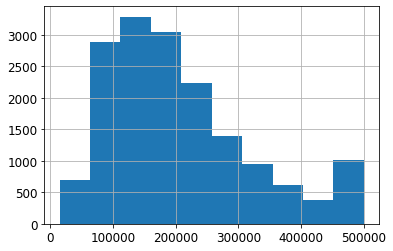

In [0]:
housing_labels.hist()
plt.show()

Ce n'est pas un résultat satisfaisant, en effet, on voit, en explorant les données, que la majorité des districts ont une `median_housing_value` comprise entre 120 et 265 mille dollars, une erreur typique de 68 mille dollars est beaucoup trop importante pour être présentable.

On est en situation de _sous-apprentissage_ (ou _under-fitting_). Cela signifie :

- soit que les données livrées à l'algorithmes d'apprentissage ne contiennent pas l'information permettant l'apprentissage,
- soit que le modèle en lui-même n'est pas assez puissant pour capter toute l'information du jeu d'entraînement.

Pour l'améliorer on peut :

1. soit relâcher les contraintes exercées sur les paramètres de notre modèle,
1. soit modifier nos données d'entrée 
1. soit sélectionner un modèle plus puissant,


#### Un modèle plus puissant

Nous allons donc essayer un modèle plus puissant : un _arbre de décision_ implémenté dans `scikit-learn` par `DecisionTreeRegressor`.

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Notre modèle est entraîné : on peut l'évaluer et calculer l'erreur-type.

In [0]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Notre modèle donnant un résultat trop parfait est en situation d'overfitting

#### Validation croisée

 `scikit-learn` propose une fonctionalité) de $k$-_fold cross validation_. Ce qui consiste à :

- diviser aléatoirement le jeu d'entraînement en $k$ sous-jeux,
- pour chacun des sous-jeux, tour à tour désignés _sous-jeu de validation_:
    * entraîner le modèle sur les $k-1$ autres sous-jeux
    * évaluer le modèle sur le sous-jeu de validation

On obtient un _array_ de $k$ scores.

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


On constate que l'erreur-type est de 71 mille dollars, soit supérieure à celle du modèle linéaire. L'_overfitting_ est avéré : ce modèle généralise mal.

> **Remarque** : La _cross-validation_ nous permet d'estimer la précision d'une estimation _via_ l'écart type.

On peut calculer le même score pour le modèle linéaire :

In [0]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


#### Un troisième modèle

Nous allons considérer la régréssion par _forêts aléatoires_ avec `RandomForestRegressor`

 Une forêt aléatoire est un ensemble d'arbres de régression entraînés sur des sous-ensembles aléatoires de données d'entraînement. 

un `RandomForestRegressor` avec les paramètres `random_state` fixé à $42$, et `n_estimators` fixé à 10.

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42, n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse

481070269.5059823

In [0]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


On obtient un bien meilleur résultat. Mais il serait interressant de :
- simplifier le modèle,
- le contraindre,
- d'obtenir un jeu de données plus volumineux,
- essayer un nombre important de modèle pour observer les différences

On va tester la _Support Vector Regression_ avec un _kernel_ linéaire :

In [0]:
from sklearn.svm import SVR

SVR_reg = SVR(C=1.0, epsilon=0.2, kernel='linear')
SVR_reg.fit(housing_prepared, housing_labels)

housing_predictions = SVR_reg.predict(housing_prepared)
SVR_rmse = mean_squared_error(housing_labels, housing_predictions)
SVR_rmse

SVR_scores = cross_val_score(SVR_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [105342.10011358 112489.24088234 110092.37163578 113403.25324922
 110638.89972542 115675.80339158 110703.54500244 114476.89008206
 113756.17971227 111520.1120808 ]
Mean: 111809.83958755006
Standard deviation: 2762.3885957347848


### Paramétrage du modèle (_fine tuning_)

#### Grid Search

`scikit-learn` propose la fonction `GridSearchCV` permet d'automatiser le paramétrage du modèle. Il faut lui fournir les valeurs à tester pour chaque hyperparamètre. Toutes les combinaisons sont évaluées par _cross-validation_.


In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # essaye 12 (3×4) combinaisons des hyperparametres
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # puis essaye 6 (2×3) combinaisons avec bootstrap à False (True étant la valeur par défaut)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# 5 sous-jeux de cross-val, ça fait en tout (12+6)*5=90 tours d'entraînement 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Le meilleurs _tuning_ est :

In [0]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

On peut obtenir directement le meilleur modèle :

In [0]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Les scores de _cross-validations_ calculés sont accessibles.

In [0]:
cv_res = grid_search.cv_results_
mts = cv_res['mean_test_score']
prms = cv_res['params']
for i,j in zip(mts, prms):
    print(i, j)

-4053756372.0286956 {'max_features': 2, 'n_estimators': 3}
-3094374223.25068 {'max_features': 2, 'n_estimators': 10}
-2849912607.859348 {'max_features': 2, 'n_estimators': 30}
-3716847114.204853 {'max_features': 4, 'n_estimators': 3}
-2781618043.191849 {'max_features': 4, 'n_estimators': 10}
-2537882895.923169 {'max_features': 4, 'n_estimators': 30}
-3441457699.7843046 {'max_features': 6, 'n_estimators': 3}
-2704644706.891946 {'max_features': 6, 'n_estimators': 10}
-2514672633.0856714 {'max_features': 6, 'n_estimators': 30}
-3348850415.197113 {'max_features': 8, 'n_estimators': 3}
-2674040747.031186 {'max_features': 8, 'n_estimators': 10}
-2468328284.7344065 {'max_features': 8, 'n_estimators': 30}
-3955789768.9978356 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
-2987516220.868609 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
-3536729252.0328445 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
-2779923754.1896353 {'bootstrap': False, 'max_features':

Nous avons atteint un _RMSE_ inférieur à $49700$, ce qui constitue un net progrès en comparaison du score précédent qui était supérieur à $52000$.

#### Randomized Search

Une autre méthode, qui passe mieux à l'échelle d'un grand espace de recherche de paramètres, et la recherche _randomisée_. Elle est similaire dans son utilisation à _grid search_ mais fixe au hasard la valeur des paramètres dans un intervalle donné. On a le contrôle sur le nombre d'itérations et sur les intervalles de recherche. Avec `RandomizedSearchCV` avec 10 itérations :

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor(random_state=42)


random_search = RandomizedSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
random_search.fit(housing_prepared, housing_labels)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

Affichons les scores obtenus :

In [0]:
random_res = random_search.cv_results_
mts = random_res['mean_test_score']
prms = random_res['params']
for i,j in zip(mts, prms):
    print(i, j)

-4053756372.0286956 {'n_estimators': 3, 'max_features': 2}
-3094374223.25068 {'n_estimators': 10, 'max_features': 2}
-2514672633.0856714 {'n_estimators': 30, 'max_features': 6}
-2537882895.923169 {'n_estimators': 30, 'max_features': 4}
-3716847114.204853 {'n_estimators': 3, 'max_features': 4}
-2987516220.868609 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
-3305165546.3795824 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
-2779923754.1896353 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
-2468328284.7344065 {'n_estimators': 30, 'max_features': 8}
-2849912607.859348 {'n_estimators': 30, 'max_features': 2}


### Methodes d'ensemble

la stratégie consistant à combiner des modèles performants peut aboutir à l'obtention d'un modèle encore plus performant. 

### Analyser les meilleurs modèles

on lister l'importance relative de chaque _feature_ pour les différents modèles :

In [0]:
feature_importances = random_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Présentons ces données autrement :

In [0]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

On constate qu'une seule parmi les catégories que l'on a _one-hot_-encodées semble avoir une quelconque importance.

### Evaluation sur le _jeu de test_

Notre travail ayant abouti a un résultat suffisamment performant, nous pouvons _enfin_ passer à l'évaluation du modèle sur le _test set_. On applique le _pipeline_ de transformation à ce jeu de test.

In [0]:
final_model = random_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

housing_transformed = full_pipeline.transform(X_test)

On peut calculer notre _RMSE_ final :

In [0]:
housing_predictions = final_model.predict(housing_prepared)
final_rmse = mean_squared_error(housing_labels, housing_predictions)
final_rmse

373372109.249443

On obtient un score encore meilleur que celui envisagé. Ce n'est pas le cas général car il est fréquent que le _bricolage_ des hyper-paramètres finisse par se spécialiser à notre _training set_. 

On va donc préparer une présentation de votre travail au client. Elle devra contenir :
- ce que nous avons appris des données
- ce que nous avons tester
- ce qui a bien fonctionné ou pas
- les hypothèses que vous avez faites
- les limites de votre système


## Bonus

### Pipeline complet : préparation et prédiction

Si l'on voulait optimiser les _hyper-paramètres_ de préparation  *et* d'apprentissage au sein d'un même `(Grid|Random)SearchCV`, il nous faut un _pipeline_ unique pour les deux tâches. 

In [0]:
full_pipeline_with_predictor = Pipeline([
        ('fp', full_pipeline),
        ('rf', RandomForestRegressor(random_state=42, n_estimators=10))
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([276490., 326860., 209860.,  47540., 230990.])

#### Sauvegarde / chargement d'un modèle 

On peut sauvegarder et recharger un modèle grâce à `joblib`. C'est utile lorsque l'entraînement de ce modèle a nécessité beaucoup de temps-machine. 

In [0]:
from sklearn.externals import joblib
joblib.dump(SVR_reg,"housing_svm_reg_linearKernel.pkl")

['housing_svm_reg_linearKernel.pkl']

In [0]:
my_loaded_model = joblib.load("housing_svm_reg_linearKernel.pkl")

In [0]:
housing_predictions = my_loaded_model.predict(housing_prepared)
loaded_model_mse = mean_squared_error(housing_labels, housing_predictions)
loaded_model_rmse = np.sqrt(loaded_model_mse)
loaded_model_rmse

111094.61981311478